In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Jan 20 19:17:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0              22W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


# Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertModel, TFBertModel, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch.nn as nn
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from keras import metrics
import gc

# Understanding BERT

This is just to show and understand the inner working of BERT transformer but won't be used as model for our data as BERT is already pre-trained and would be a waste to not take advantage of it

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [5]:
class SimpleSelfAttention(torch.nn.Module):
    def __init__(self, embed_size):
        super(SimpleSelfAttention, self).__init__()
        self.embed_size = embed_size

        self.query_projection = nn.Linear(embed_size, embed_size)
        self.key_projection = nn.Linear(embed_size, embed_size)
        self.value_projection = nn.Linear(embed_size, embed_size)

        self.linear = nn.Linear(embed_size, embed_size)
        self.relu = nn.ReLU()

        self.layer_norm1 = nn.LayerNorm(embed_size)
        self.layer_norm2 = nn.LayerNorm(embed_size)

    def forward(self, x):
        # Project the input to obtain queries, keys, and values
        queries = self.query_projection(x)
        keys = self.key_projection(x)
        values = self.value_projection(x)

        # Compute scaled dot-product attention
        attention_scores = torch.matmul(queries, keys.transpose(-2, -1))
        attention_scores = attention_scores / np.sqrt(self.embed_size)
        attention_weights = F.softmax(attention_scores, dim=-1)

        # Apply attention to values
        output = torch.matmul(attention_weights, values)

        # Add & Norm Layer
        output = self.layer_norm1(x + output)

        # Additional feedforward layer with ReLU activation
        output = self.linear(self.relu(self.linear(output)))

        # Add & Norm Layer
        output = self.layer_norm2(x + output)

        return output

class SimpleSelfAttentionClassifier(torch.nn.Module):
    def __init__(self, embed_size, num_classes):
        super(SimpleSelfAttentionClassifier, self).__init__()
        self.self_attention = SimpleSelfAttention(embed_size)
        self.classification = nn.Linear(embed_size, num_classes)

    def forward(self, x):
        # Apply self-attention
        attention_output = self.self_attention(x)

        # Global average pooling to get a fixed-size representation
        pooled_output = attention_output.mean(dim=1)

        # Classification layer
        logits = self.classification(pooled_output)
        return logits

In [6]:
embed_size = 64 #each token is a 64-d vector

# Create an instance of the model
attention_model = SimpleSelfAttention(embed_size)

# Example input
batch_size = 16 #during one iteration, 16 training examples simultaneously
sequence_length = 10
input_data = torch.randn(batch_size, sequence_length, embed_size)

# Forward pass through the attention model
output = attention_model(input_data)

print("Input shape:", input_data.shape)
print("Output shape:", output.shape)


Input shape: torch.Size([16, 10, 64])
Output shape: torch.Size([16, 10, 64])


# Load the data
To gain time, the data is already processed and splitted in the Data_Exploration_Processing notebook

In [75]:
y_train = tf.io.parse_tensor(open('/content/drive/MyDrive/Colab Notebooks/TB/splitdataset/y_train.tf', 'rb').read(), out_type=tf.float32)
y_val = tf.io.parse_tensor(open('/content/drive/MyDrive/Colab Notebooks/TB/splitdataset/y_val.tf', 'rb').read(), out_type=tf.float32)
y_test = tf.io.parse_tensor(open('/content/drive/MyDrive/Colab Notebooks/TB/splitdataset/y_test.tf', 'rb').read(), out_type=tf.float32)

train_claim_input_ids = tf.io.parse_tensor(open('/content/drive/MyDrive/Colab Notebooks/TB/splitdataset/train_claim_input_ids.tf', 'rb').read(), out_type=tf.int32)
train_claim_attention_mask = tf.io.parse_tensor(open('/content/drive/MyDrive/Colab Notebooks/TB/splitdataset/train_claim_attention_mask.tf', 'rb').read(), out_type=tf.int32)
train_ets_input_ids = tf.io.parse_tensor(open('/content/drive/MyDrive/Colab Notebooks/TB/splitdataset/train_ets_input_ids.tf', 'rb').read(), out_type=tf.int32)
train_ets_attention_mask = tf.io.parse_tensor(open('/content/drive/MyDrive/Colab Notebooks/TB/splitdataset/train_ets_attention_mask.tf', 'rb').read(), out_type=tf.int32)

val_claim_input_ids = tf.io.parse_tensor(open('/content/drive/MyDrive/Colab Notebooks/TB/splitdataset/val_claim_input_ids.tf', 'rb').read(), out_type=tf.int32)
val_claim_attention_mask = tf.io.parse_tensor(open('/content/drive/MyDrive/Colab Notebooks/TB/splitdataset/val_claim_attention_mask.tf', 'rb').read(), out_type=tf.int32)
val_ets_input_ids = tf.io.parse_tensor(open('/content/drive/MyDrive/Colab Notebooks/TB/splitdataset/val_ets_input_ids.tf', 'rb').read(), out_type=tf.int32)
val_ets_attention_mask = tf.io.parse_tensor(open('/content/drive/MyDrive/Colab Notebooks/TB/splitdataset/val_ets_attention_mask.tf', 'rb').read(), out_type=tf.int32)

test_claim_input_ids = tf.io.parse_tensor(open('/content/drive/MyDrive/Colab Notebooks/TB/splitdataset/test_claim_input_ids.tf', 'rb').read(), out_type=tf.int32)
test_claim_attention_mask = tf.io.parse_tensor(open('/content/drive/MyDrive/Colab Notebooks/TB/splitdataset/test_claim_attention_mask.tf', 'rb').read(), out_type=tf.int32)
test_ets_input_ids = tf.io.parse_tensor(open('/content/drive/MyDrive/Colab Notebooks/TB/splitdataset/test_ets_input_ids.tf', 'rb').read(), out_type=tf.int32)
test_ets_attention_mask = tf.io.parse_tensor(open('/content/drive/MyDrive/Colab Notebooks/TB/splitdataset/test_ets_attention_mask.tf', 'rb').read(), out_type=tf.int32)

In [43]:
print(f'Shape and datatype of Claim Input IDs:\n{train_claim_input_ids.shape}\n{type(train_claim_input_ids)}\n')
print(f'Shape and datatype of Claim Attention Mask:\n{train_claim_attention_mask.shape}\n{type(train_claim_attention_mask)}\n')

Shape and datatype of Claim Input IDs:
(6219, 512)
<class 'tensorflow.python.framework.ops.EagerTensor'>

Shape and datatype of Claim Attention Mask:
(6219, 512)
<class 'tensorflow.python.framework.ops.EagerTensor'>



# Building the BERT Models

## SimpleBERTClassifer (one input, Claims or ETS)

In [59]:
class SimpleBertClassifier(tf.keras.Model):
    def __init__(self, num_labels, max_length=128):
        super(SimpleBertClassifier, self).__init__()

        # BERT model layers
        self.bert_model = TFBertModel.from_pretrained('bert-base-uncased')

        # Input layers
        self.input_ids = Input(shape=(max_length, ), dtype=tf.int32, name="input_ids")
        self.attention_mask = Input(shape=(max_length, ), dtype=tf.int32, name="attention_mask")

        # Dense layers for classification
        self.dense1 = Dense(128, activation='relu')
        self.output_layer = Dense(num_labels, activation='sigmoid')

    def call(self, inputs, training=False):
        # Extract inputs
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']

        # BERT forward pass
        print(f"Input IDs shape: {input_ids.shape}")
        print(f"Attention Mask shape: {attention_mask.shape}")

        bert_outputs = self.bert_model(input_ids, attention_mask=attention_mask)

        print(f"Bert Outputs keys: {bert_outputs.keys()}")
        pooled_output = bert_outputs.pooler_output

        # Dense layers for classification
        print(f"Pooled Output shape: {pooled_output.shape}")
        dense1_output = self.dense1(pooled_output)
        output = self.output_layer(dense1_output)

        print(f"Output shape: {output.shape}")

        return output

In [60]:
# Dummy data for building the model
dummy_data = {
    'input_ids': tf.ones((1, 512), dtype=tf.int32),
    'attention_mask': tf.ones((1, 512), dtype=tf.int32)
}

### Model with claims only

In [61]:
model_claim = SimpleBertClassifier(num_labels=1, max_length=512)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [62]:
model_claim.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy',
                       metrics.Precision(name='precision'),
                       metrics.Recall(name='recall'),
                       metrics.AUC(name='auc'),
                       metrics.FalsePositives(name='false_positives'),
                       metrics.FalseNegatives(name='false_negatives'),
                       metrics.TrueNegatives(name='true_negatives'),
                       metrics.F1Score(name='f1_score', average='micro')
                       ])

In [63]:
_ = model_claim(dummy_data)
model_claim.summary()

Input IDs shape: (1, 512)
Attention Mask shape: (1, 512)
Bert Outputs keys: odict_keys(['last_hidden_state', 'pooler_output'])
Pooled Output shape: (1, 768)
Output shape: (1, 1)
Model: "simple_bert_classifier_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_bert_model_7 (TFBertMod  multiple                  109482240 
 el)                                                             
                                                                 
 dense_14 (Dense)            multiple                  98432     
                                                                 
 dense_15 (Dense)            multiple                  129       
                                                                 
Total params: 109580801 (418.02 MB)
Trainable params: 109580801 (418.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Model with ETS only

In [64]:
model_ets = SimpleBertClassifier(num_labels=1, max_length=512)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [65]:
model_ets.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy',
                       metrics.Precision(name='precision'),
                       metrics.Recall(name='recall'),
                       metrics.AUC(name='auc'),
                       metrics.FalsePositives(name='false_positives'),
                       metrics.FalseNegatives(name='false_negatives'),
                       metrics.TrueNegatives(name='true_negatives'),
                       metrics.F1Score(name='f1_score', average='micro')])

In [66]:
_ = model_ets(dummy_data)
model_ets.summary()

Input IDs shape: (1, 512)
Attention Mask shape: (1, 512)
Bert Outputs keys: odict_keys(['last_hidden_state', 'pooler_output'])
Pooled Output shape: (1, 768)
Output shape: (1, 1)
Model: "simple_bert_classifier_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_bert_model_8 (TFBertMod  multiple                  109482240 
 el)                                                             
                                                                 
 dense_16 (Dense)            multiple                  98432     
                                                                 
 dense_17 (Dense)            multiple                  129       
                                                                 
Total params: 109580801 (418.02 MB)
Trainable params: 109580801 (418.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## DoubleBERTClassifer (two inputs, Claim and ETS)

This model is able to be trained with both Claims and ETS or only with Claims. This is because it is able to predict the label of a claim without any ETS inputs as, when delivered, users will only inputs claims. Thanks to this, the model should also be benefiting from the ETS data when a user use it !

In [67]:
class DoubleBertClassifier(tf.keras.Model):
    def __init__(self, num_labels, max_length=128):
        super(DoubleBertClassifier, self).__init__()

        # BERT model layers
        self.bert_model = TFBertModel.from_pretrained('bert-base-uncased')

        # Input layers for claim
        self.claim_input_ids = Input(shape=(max_length, ), dtype=tf.int32, name="claim_input_ids")
        self.claim_attention_mask = Input(shape=(max_length, ), dtype=tf.int32, name="claim_attention_mask")

        # Input layers for ETS
        self.ets_input_ids = Input(shape=(max_length, ), dtype=tf.int32, name="ets_input_ids")
        self.ets_attention_mask = Input(shape=(max_length, ), dtype=tf.int32, name="ets_attention_mask")

        # Dense layers for classification
        self.dense1 = Dense(128, activation='relu')
        self.output_layer = Dense(num_labels, activation='sigmoid')

    def call(self, inputs, training=False):
        # Extract inputs for claim
        claim_input_ids = inputs['claim_input_ids'][:,:115]
        claim_attention_mask = inputs['claim_attention_mask'][:,:115]

        # Extract inputs for ETS
        ets_input_ids = inputs['ets_input_ids'][:,:397]
        ets_attention_mask = inputs['ets_attention_mask'][:,:397]

        print("Claim Input Shape: ", claim_input_ids.shape)
        print("Claim Attention Mask Shape: ", claim_attention_mask.shape)

        print("ETS Input Shape: ", claim_input_ids.shape)
        print("ETS Attention Mask Shape: ", claim_attention_mask.shape)

        if tf.reduce_sum(ets_input_ids) == 0:
          # Only claims used
          concatenated_input_ids = claim_input_ids
          concatenated_attention_mask = claim_attention_mask
        else:
          # Concate claim and ETS
          concatenated_input_ids = tf.concat([claim_input_ids, ets_input_ids], axis=1)
          concatenated_attention_mask = tf.concat([claim_attention_mask, ets_attention_mask], axis=1)

        # Print shapes for debugging
        print("Input Shape: ", concatenated_input_ids.shape)
        print("Attention Mask Shape: ", concatenated_attention_mask.shape)

        # BERT forward pass
        bert_outputs = self.bert_model(input_ids=concatenated_input_ids, attention_mask=concatenated_attention_mask)
        pooled_output = bert_outputs.pooler_output

        # Dense layers for classification
        dense1_output = self.dense1(pooled_output)
        output = self.output_layer(dense1_output)

        return output

Additional information :


*   If the model is delivered and a user wants to label, they can put None as variables for the ets_input_ids and ets_attention_maks
*   Because the maximum number of tokens across all claims is 107 and the average is 18, Claims input are trunc at 115 so that we get the most of the ETS.
*   The "if" in the call function allows the use of placesholders for ETS inputs and attention mask so that the model can predict the label only once delivered  





In [68]:
double_model = DoubleBertClassifier(num_labels=1, max_length=512)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [69]:
double_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy',
                       metrics.Precision(name='precision'),
                       metrics.Recall(name='recall'),
                       metrics.AUC(name='auc'),
                       metrics.FalsePositives(name='false_positives'),
                       metrics.FalseNegatives(name='false_negatives'),
                       metrics.TrueNegatives(name='true_negatives'),
                       metrics.F1Score(name='f1_score', average='micro')])

In [70]:
# Dummy data for building the model
dummy_data = {
    'claim_input_ids': tf.ones((1, 512), dtype=tf.int32),
    'claim_attention_mask': tf.ones((1, 512), dtype=tf.int32),
    'ets_input_ids': tf.ones((1, 512), dtype=tf.int32),
    'ets_attention_mask': tf.ones((1, 512), dtype=tf.int32)
}

In [71]:
# Call double_model model on the dummy data to build it
_ = double_model(dummy_data)

# Now you can print the model summary
double_model.summary()

Claim Input Shape:  (1, 115)
Claim Attention Mask Shape:  (1, 115)
ETS Input Shape:  (1, 115)
ETS Attention Mask Shape:  (1, 115)
Input Shape:  (1, 512)
Attention Mask Shape:  (1, 512)
Model: "double_bert_classifier_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_bert_model_9 (TFBertMod  multiple                  109482240 
 el)                                                             
                                                                 
 dense_18 (Dense)            multiple                  98432     
                                                                 
 dense_19 (Dense)            multiple                  129       
                                                                 
Total params: 109580801 (418.02 MB)
Trainable params: 109580801 (418.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Model Checkpoints


In [78]:
model_checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/TB/model_checkpoints/'

model_checkpoint_claim = ModelCheckpoint(
    filepath=model_checkpoint_path + 'model_claim_weights_{epoch:02d}_{val_loss:.4f}.h5',
    monitor='val_auc',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch',
    mode='max',
    verbose=1
)

model_checkpoint_ets = ModelCheckpoint(
    filepath=model_checkpoint_path + 'model_ets_weights_{epoch:02d}_{val_loss:.4f}.h5',
    monitor='val_auc',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch',
    mode='max',
    verbose=1
)

model_checkpoint_double = ModelCheckpoint(
    filepath=model_checkpoint_path + 'model_double_weights_{epoch:02d}_{val_loss:.4f}.h5',
    monitor='val_auc',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch',
    mode='max',
    verbose=1
)

# Hyperparameters

In [73]:
subset_size = 100
batch_size = 10
num_epochs = 11

# SimpleBERTClassifier (Claims)

### Training

In [79]:
history_model_claim = model_claim.fit(
    {'input_ids': train_claim_input_ids, 'attention_mask': train_claim_attention_mask},
    y_train,
    epochs=num_epochs,
    validation_data=({'input_ids': val_claim_input_ids, 'attention_mask': val_claim_attention_mask}, y_val),
    batch_size=batch_size,
    callbacks=[model_checkpoint_claim]
)

Epoch 1/11
622/622 [==============================] - ETA: 0s - loss: 0.0406 - accuracy: 0.9855 - precision: 0.9867 - recall: 0.9827 - auc: 0.9982 - false_positives: 39.0000 - false_negatives: 51.0000 - true_negatives: 3225.0000 - f1_score: 0.6442
Epoch 1: val_auc improved from -inf to 0.92471, saving model to /content/drive/MyDrive/Colab Notebooks/TB/model_checkpoints/model_claim_weights_01_0.5480.h5
622/622 [==============================] - 262s 421ms/step - loss: 0.0406 - accuracy: 0.9855 - precision: 0.9867 - recall: 0.9827 - auc: 0.9982 - false_positives: 39.0000 - false_negatives: 51.0000 - true_negatives: 3225.0000 - f1_score: 0.6442 - val_loss: 0.5480 - val_accuracy: 0.8688 - val_precision: 0.8591 - val_recall: 0.8615 - val_auc: 0.9247 - val_false_positives: 103.0000 - val_false_negatives: 101.0000 - val_true_negatives: 723.0000 - val_f1_score: 0.6384
Epoch 2/11
622/622 [==============================] - ETA: 0s - loss: 0.0273 - accuracy: 0.9921 - precision: 0.9922 - recall: 0

In [80]:
history_model_claim.history

{'loss': [0.040638212114572525,
  0.027273016050457954,
  0.025516146793961525,
  0.023329952731728554,
  0.02020946331322193,
  0.01713687740266323,
  0.012336119078099728,
  0.008586396463215351,
  0.010477126576006413,
  0.012212452478706837,
  0.018474800512194633],
 'accuracy': [0.9855282306671143,
  0.9921209216117859,
  0.9919601082801819,
  0.9926033020019531,
  0.9938896894454956,
  0.9945328831672668,
  0.9966232776641846,
  0.9966232776641846,
  0.9959800839424133,
  0.9964624643325806,
  0.9961408376693726],
 'precision': [0.986748218536377,
  0.9922086596488953,
  0.9912073016166687,
  0.9915512204170227,
  0.9939045310020447,
  0.9942470192909241,
  0.9962787628173828,
  0.9966147541999817,
  0.9956021904945374,
  0.9969502091407776,
  0.9959390759468079],
 'recall': [0.982741117477417,
  0.9912013411521912,
  0.9918781518936157,
  0.992893397808075,
  0.9932318329811096,
  0.9942470192909241,
  0.9966158866882324,
  0.9962775111198425,
  0.9959390759468079,
  0.995600700

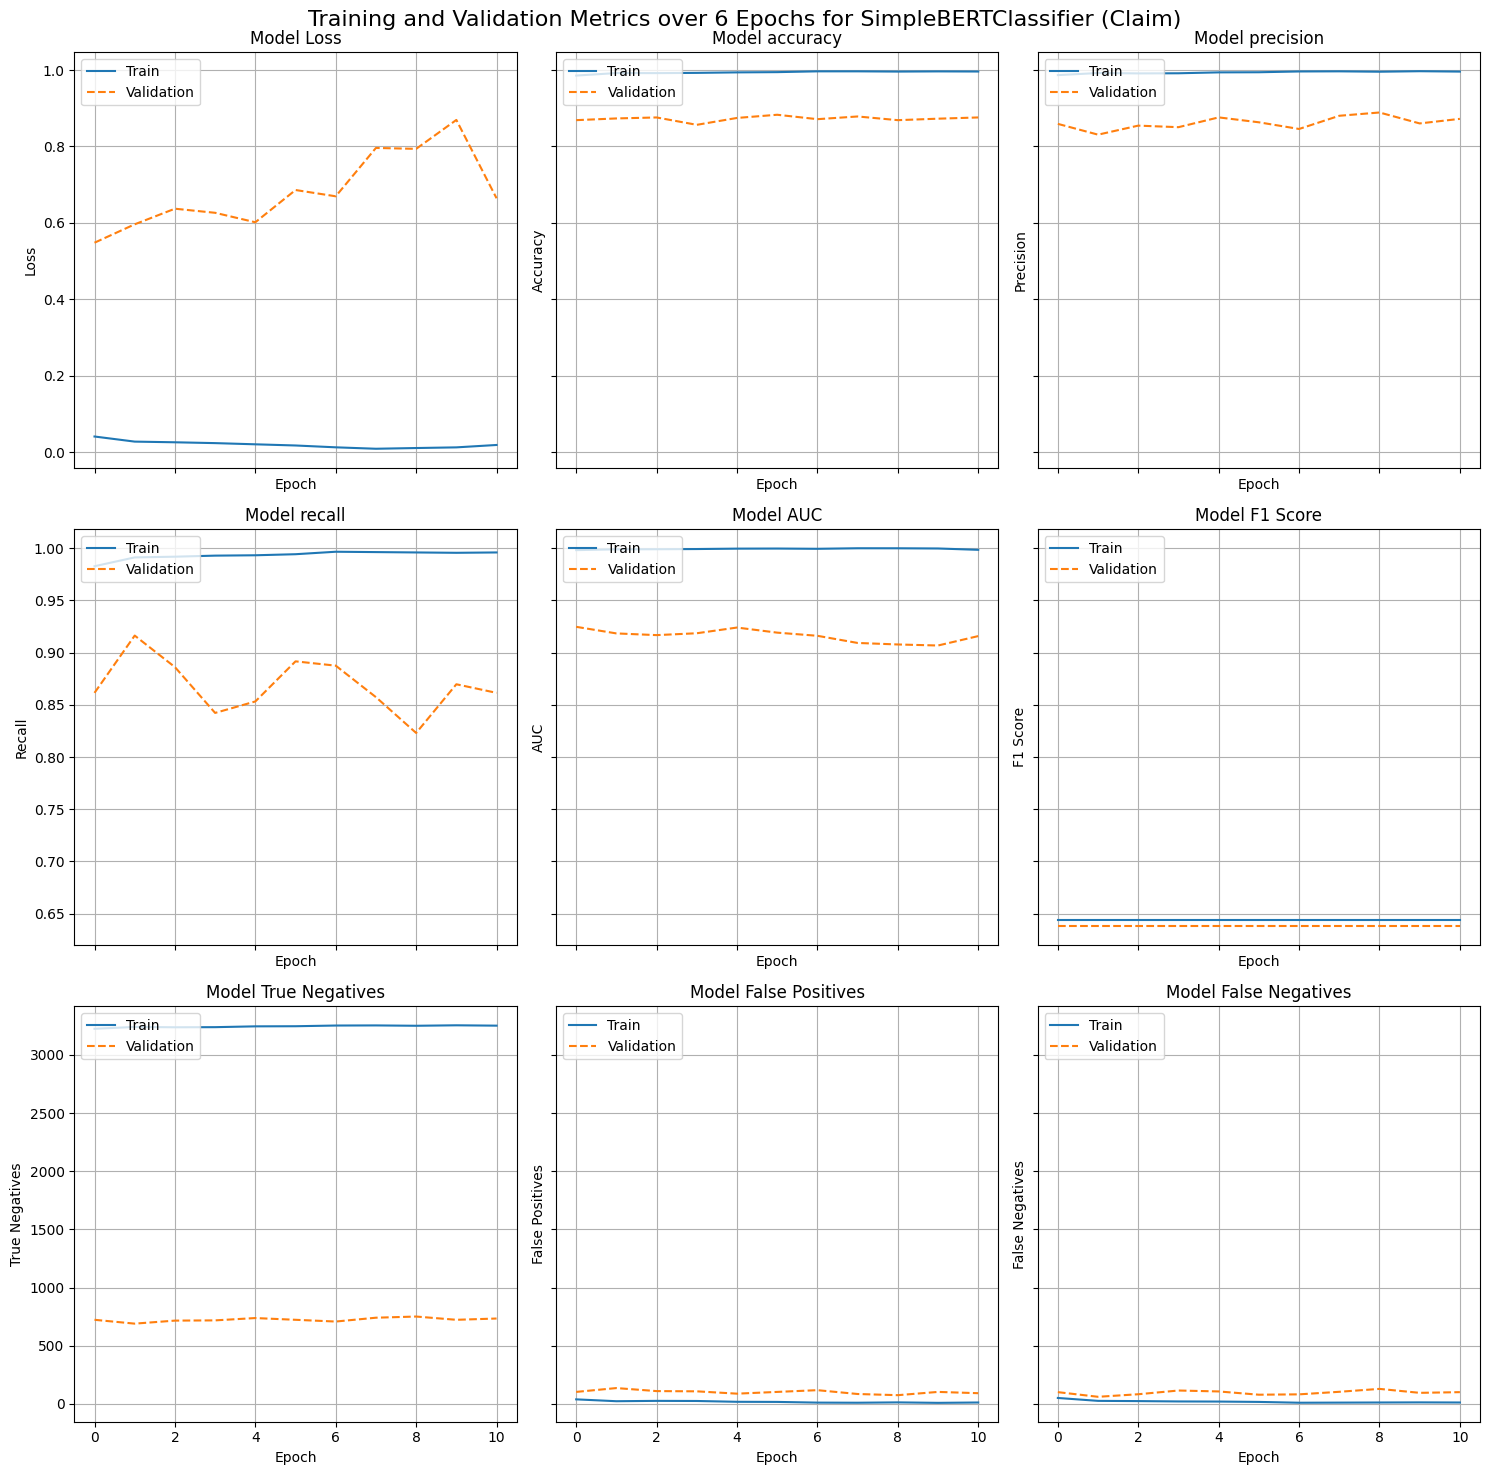

In [81]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=(True, True, False), sharey='row')

# Plot training & validation loss values
axes[0, 0].plot(history_model_claim.history['loss'])
axes[0, 0].plot(history_model_claim.history['val_loss'], linestyle='dashed')
axes[0, 0].set_title('Model Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend(['Train', 'Validation'], loc='upper left')
axes[0, 0].grid(True)

# Plot training & validation accuracy values
axes[0, 1].plot(history_model_claim.history['accuracy'])
axes[0, 1].plot(history_model_claim.history['val_accuracy'], linestyle='dashed')
axes[0, 1].set_title('Model accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend(['Train', 'Validation'], loc='upper left')
axes[0, 1].grid(True)

# Plot training & validation precision values
axes[0, 2].plot(history_model_claim.history['precision'])
axes[0, 2].plot(history_model_claim.history['val_precision'], linestyle='dashed')
axes[0, 2].set_title('Model precision')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Precision')
axes[0, 2].legend(['Train', 'Validation'], loc='upper left')
axes[0, 2].grid(True)

# Plot training & validation recall values
axes[1, 0].plot(history_model_claim.history['recall'])
axes[1, 0].plot(history_model_claim.history['val_recall'], linestyle='dashed')
axes[1, 0].set_title('Model recall')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].legend(['Train', 'Validation'], loc='upper left')
axes[1, 0].grid(True)

# Plot training & validation auc values
axes[1, 1].plot(history_model_claim.history['auc'])
axes[1, 1].plot(history_model_claim.history['val_auc'], linestyle='dashed')
axes[1, 1].set_title('Model AUC')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('AUC')
axes[1, 1].legend(['Train', 'Validation'], loc='upper left')
axes[1, 1].grid(True)

# Plot training & validation f1_score values
axes[1, 2].plot(history_model_claim.history['f1_score'])
axes[1, 2].plot(history_model_claim.history['val_f1_score'], linestyle='dashed')
axes[1, 2].set_title('Model F1 Score')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('F1 Score')
axes[1, 2].legend(['Train', 'Validation'], loc='upper left')
axes[1, 2].grid(True)

# Plot training & validation true negatives values
axes[2, 0].plot(history_model_claim.history['true_negatives'])
axes[2, 0].plot(history_model_claim.history['val_true_negatives'], linestyle='dashed')
axes[2, 0].set_title('Model True Negatives')
axes[2, 0].set_xlabel('Epoch')
axes[2, 0].set_ylabel('True Negatives')
axes[2, 0].legend(['Train', 'Validation'], loc='upper left')
axes[2, 0].grid(True)

# Plot training & validation false positives values
axes[2, 1].plot(history_model_claim.history['false_positives'])
axes[2, 1].plot(history_model_claim.history['val_false_positives'], linestyle='dashed')
axes[2, 1].set_title('Model False Positives')
axes[2, 1].set_xlabel('Epoch')
axes[2, 1].set_ylabel('False Positives')
axes[2, 1].legend(['Train', 'Validation'], loc='upper left')
axes[2, 1].grid(True)

# Plot training & validation false negatives values
axes[2, 2].plot(history_model_claim.history['false_negatives'])
axes[2, 2].plot(history_model_claim.history['val_false_negatives'], linestyle='dashed')
axes[2, 2].set_title('Model False Negatives')
axes[2, 2].set_xlabel('Epoch')
axes[2, 2].set_ylabel('False Negatives')
axes[2, 2].legend(['Train', 'Validation'], loc='upper left')
axes[2, 2].grid(True)

plt.suptitle('Training and Validation Metrics over 6 Epochs for SimpleBERTClassifier (Claim)', fontsize=16)
plt.tight_layout()
plt.show()

## Evaluate

Load the weights from the model with the smallest validation loss

In [83]:
model_claim.load_weights(model_checkpoint_path + 'model_claim_weights_01_0.5480.h5') #first epoch

In [84]:
evaluation_model_claim = model_claim.evaluate({'input_ids': test_claim_input_ids, 'attention_mask': test_claim_attention_mask},
                            y_test)

metrics_names = model_claim.metrics_names

print('Metrics for the SimpleBERTClassifier (Claim) model with the lowest validation loss')
for metric_name, metric_value in zip(metrics_names, evaluation_model_claim):
    print(f"{metric_name}: {metric_value:.4f}")

61/61 [==============================] - 23s 384ms/step - loss: 0.5136 - accuracy: 0.8714 - precision: 0.8742 - recall: 0.8594 - auc: 0.9255 - false_positives: 117.0000 - false_negatives: 133.0000 - true_negatives: 881.0000 - f1_score: 0.6547
Metrics for the SimpleBERTClassifier (Claim) model with the lowest validation loss
loss: 0.5136
accuracy: 0.8714
precision: 0.8742
recall: 0.8594
auc: 0.9255
false_positives: 117.0000
false_negatives: 133.0000
true_negatives: 881.0000
f1_score: 0.6547


## Prediction

RESULTS :

In [85]:
# Using the model to make predictions on validation data
predictions_model_claim = model_claim.predict({'input_ids': test_claim_input_ids, 'attention_mask': test_claim_attention_mask})
predicted_labels = np.round(predictions_model_claim)

Input IDs shape: (None, 512)
Attention Mask shape: (None, 512)
Bert Outputs keys: odict_keys(['last_hidden_state', 'pooler_output'])
Pooled Output shape: (None, 768)
Output shape: (None, 1)
61/61 [==============================] - 26s 379ms/step


In [86]:
print(f'Predicted labels: {predictions_model_claim}')
print(f'Rounded predicted labels: {predicted_labels}')

accuracy_model_claim = accuracy_score(y_test, predicted_labels)
print(f'Accuracy: {accuracy_model_claim:.4f}')
print()
# Generate a confusion matrix
conf_mat_model_claim = confusion_matrix(y_test, predicted_labels)
print('Confusion Matrix:')
print(conf_mat_model_claim)

Predicted labels: [[1.4877165e-03]
 [9.9946517e-01]
 [4.4742625e-04]
 ...
 [9.9901068e-01]
 [8.1310891e-02]
 [8.8716608e-01]]
Rounded predicted labels: [[0.]
 [1.]
 [0.]
 ...
 [1.]
 [0.]
 [1.]]
Accuracy: 0.8714

Confusion Matrix:
[[881 117]
 [133 813]]


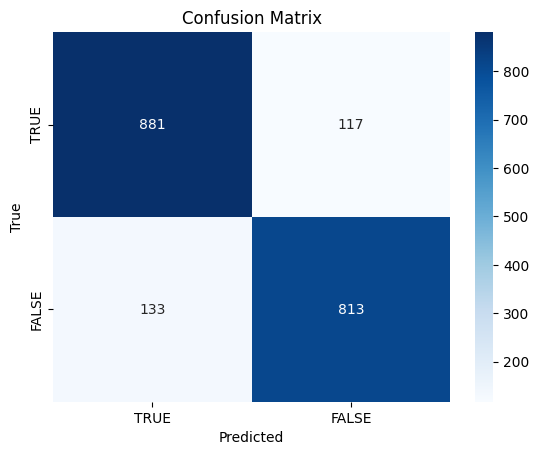

In [87]:
# Plot the confusion matrix with axis labels using seaborn
labels = ['TRUE', 'FALSE']
sns.heatmap(conf_mat_model_claim, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [88]:
model_claim.save_weights("/content/drive/MyDrive/Colab Notebooks/TB/final_weights/SimpleBERTClassifierCLAIM_weights", save_format="tf")

In [ ]:
#model_claim.save("SimpleBERTClassifier_Claim", save_format="tf")

Input IDs shape: (None, 512)
Attention Mask shape: (None, 512)
Bert Outputs keys: odict_keys(['last_hidden_state', 'pooler_output'])
Pooled Output shape: (None, 768)
Output shape: (None, 1)
Input IDs shape: (None, 512)
Attention Mask shape: (None, 512)
Bert Outputs keys: odict_keys(['last_hidden_state', 'pooler_output'])
Pooled Output shape: (None, 768)
Output shape: (None, 1)
Input IDs shape: (None, 512)
Attention Mask shape: (None, 512)
Bert Outputs keys: odict_keys(['last_hidden_state', 'pooler_output'])
Pooled Output shape: (None, 768)
Output shape: (None, 1)


In [ ]:
#del model_claim
#del history_model_claim
#del evaluation_model_claim
#del predictions_model_claim

In [89]:
gc.collect()

8960

# SimpleBERTClassifier (ETS)

## Training

RESULTS :

In [90]:
history_model_ets = model_ets.fit(
    {'input_ids': train_ets_input_ids, 'attention_mask': train_ets_attention_mask},
    y_train,
    epochs=num_epochs,
    validation_data=({'input_ids': val_ets_input_ids, 'attention_mask': val_ets_attention_mask}, y_val),
    batch_size=batch_size,
    callbacks=[model_checkpoint_ets]
)

Epoch 1/11
Input IDs shape: (None, 512)
Attention Mask shape: (None, 512)
Bert Outputs keys: odict_keys(['last_hidden_state', 'pooler_output'])
Pooled Output shape: (None, 768)
Output shape: (None, 1)
Input IDs shape: (None, 512)
Attention Mask shape: (None, 512)
Bert Outputs keys: odict_keys(['last_hidden_state', 'pooler_output'])
Pooled Output shape: (None, 768)
Output shape: (None, 1)
622/622 [==============================] - ETA: 0s - loss: 0.5000 - accuracy: 0.7974 - precision: 0.7932 - recall: 0.7760 - auc: 0.8189 - false_positives: 598.0000 - false_negatives: 662.0000 - true_negatives: 2666.0000 - f1_score: 0.6442Input IDs shape: (None, 512)
Attention Mask shape: (None, 512)
Bert Outputs keys: odict_keys(['last_hidden_state', 'pooler_output'])
Pooled Output shape: (None, 768)
Output shape: (None, 1)

Epoch 1: val_auc improved from -inf to 0.82789, saving model to /content/drive/MyDrive/Colab Notebooks/TB/model_checkpoints/model_ets_weights_01_0.4818.h5
622/622 [================

In [93]:
history_model_ets.history

{'loss': [0.4999997615814209,
  0.458292692899704,
  0.38163620233535767,
  0.27521488070487976,
  0.2235661894083023,
  0.18304848670959473,
  0.16057996451854706,
  0.12653996050357819,
  0.10685118287801743,
  0.10935279726982117,
  0.08682162314653397],
 'accuracy': [0.7973950505256653,
  0.8100981116294861,
  0.8486894965171814,
  0.8940343856811523,
  0.9068982005119324,
  0.916385293006897,
  0.9258723258972168,
  0.9379321336746216,
  0.9459720253944397,
  0.9495095610618591,
  0.9562630653381348],
 'precision': [0.7931511402130127,
  0.7940981388092041,
  0.8034960627555847,
  0.8346938490867615,
  0.8459522128105164,
  0.8694992661476135,
  0.8999358415603638,
  0.9232289791107178,
  0.9413549304008484,
  0.942378580570221,
  0.9506214261054993],
 'recall': [0.7759729027748108,
  0.8104906678199768,
  0.9021996855735779,
  0.9688663482666016,
  0.9830795526504517,
  0.9695431590080261,
  0.9495769739151001,
  0.948223352432251,
  0.9451776742935181,
  0.9519458413124084,
  0.

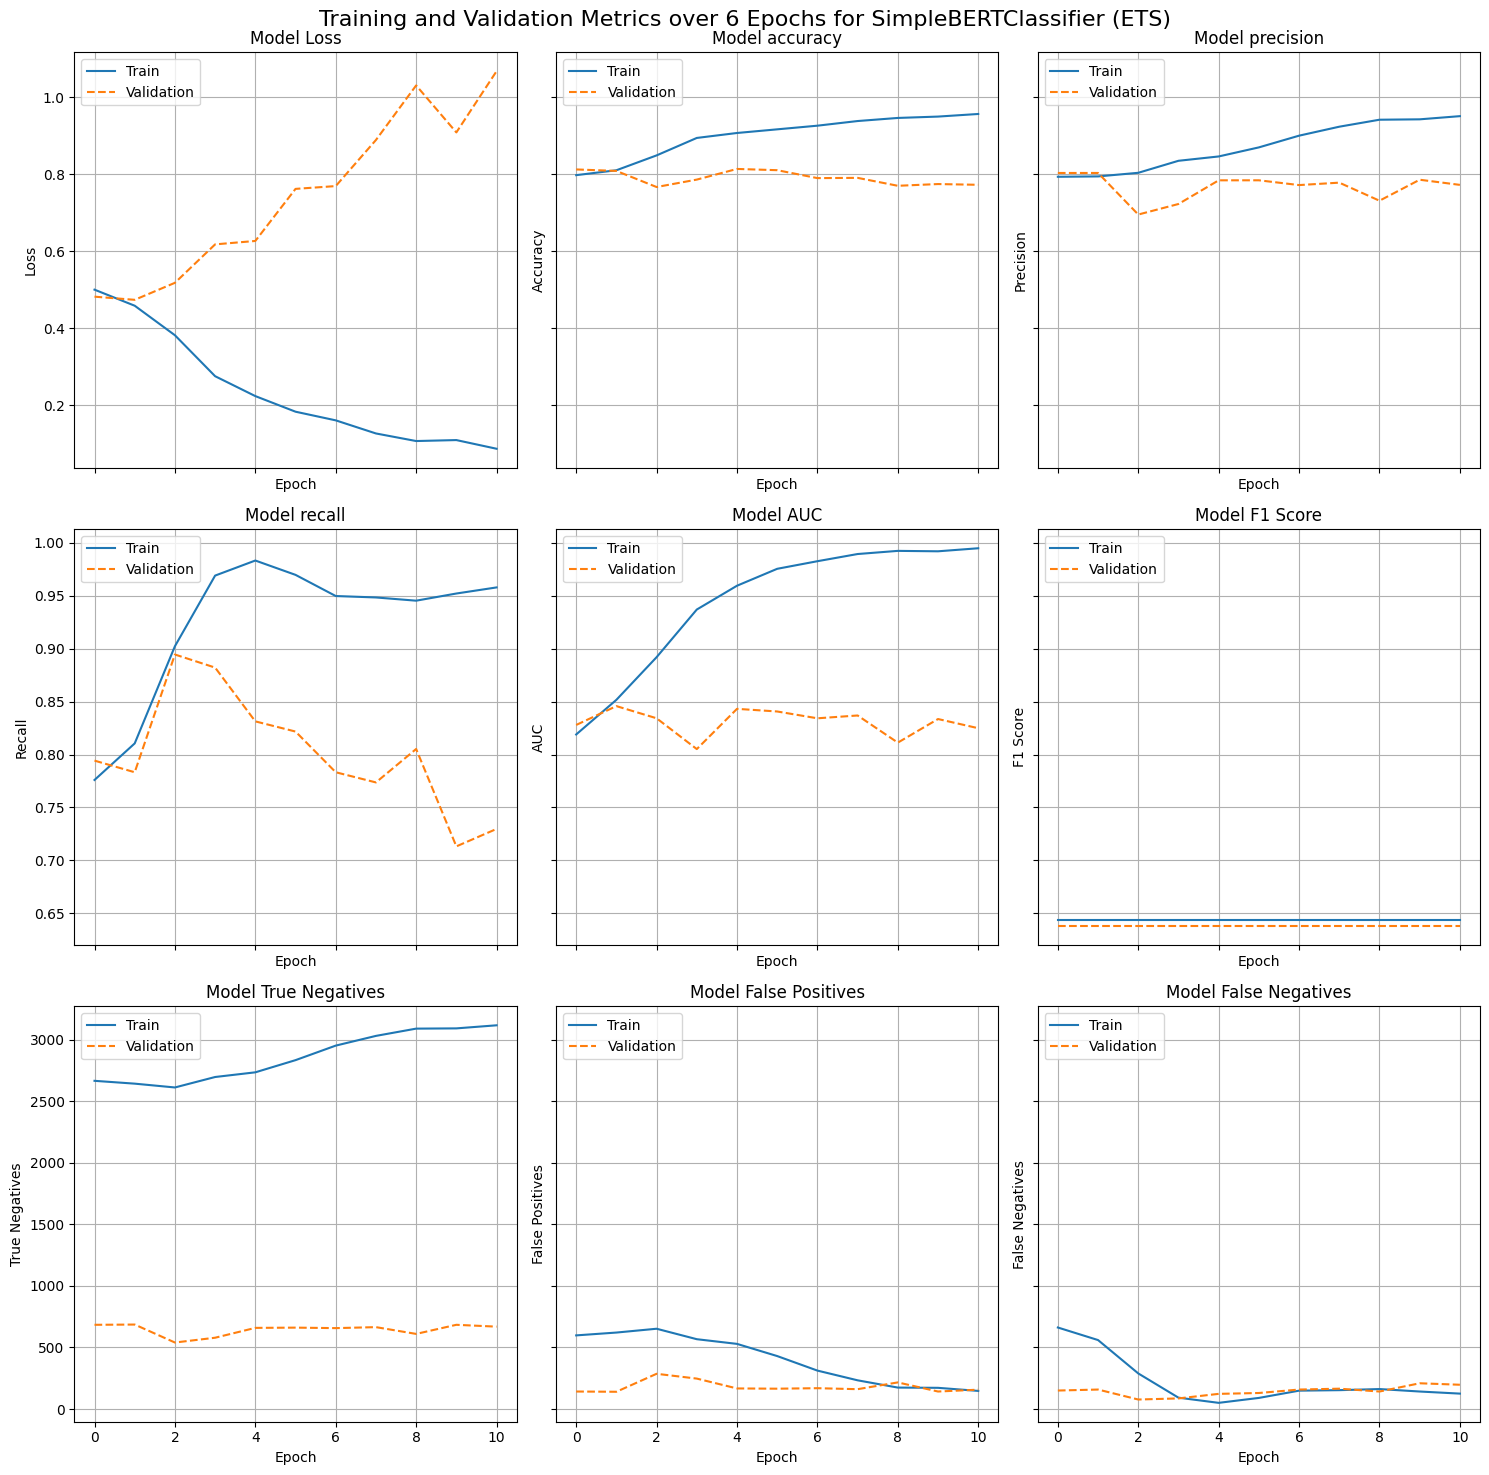

In [94]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=(True, True, False), sharey='row')

# Plot training & validation loss values
axes[0, 0].plot(history_model_ets.history['loss'])
axes[0, 0].plot(history_model_ets.history['val_loss'], linestyle='dashed')
axes[0, 0].set_title('Model Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend(['Train', 'Validation'], loc='upper left')
axes[0, 0].grid(True)

# Plot training & validation accuracy values
axes[0, 1].plot(history_model_ets.history['accuracy'])
axes[0, 1].plot(history_model_ets.history['val_accuracy'], linestyle='dashed')
axes[0, 1].set_title('Model accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend(['Train', 'Validation'], loc='upper left')
axes[0, 1].grid(True)

# Plot training & validation precision values
axes[0, 2].plot(history_model_ets.history['precision'])
axes[0, 2].plot(history_model_ets.history['val_precision'], linestyle='dashed')
axes[0, 2].set_title('Model precision')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Precision')
axes[0, 2].legend(['Train', 'Validation'], loc='upper left')
axes[0, 2].grid(True)

# Plot training & validation recall values
axes[1, 0].plot(history_model_ets.history['recall'])
axes[1, 0].plot(history_model_ets.history['val_recall'], linestyle='dashed')
axes[1, 0].set_title('Model recall')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].legend(['Train', 'Validation'], loc='upper left')
axes[1, 0].grid(True)

# Plot training & validation auc values
axes[1, 1].plot(history_model_ets.history['auc'])
axes[1, 1].plot(history_model_ets.history['val_auc'], linestyle='dashed')
axes[1, 1].set_title('Model AUC')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('AUC')
axes[1, 1].legend(['Train', 'Validation'], loc='upper left')
axes[1, 1].grid(True)

# Plot training & validation f1_score values
axes[1, 2].plot(history_model_ets.history['f1_score'])
axes[1, 2].plot(history_model_ets.history['val_f1_score'], linestyle='dashed')
axes[1, 2].set_title('Model F1 Score')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('F1 Score')
axes[1, 2].legend(['Train', 'Validation'], loc='upper left')
axes[1, 2].grid(True)

# Plot training & validation true negatives values
axes[2, 0].plot(history_model_ets.history['true_negatives'])
axes[2, 0].plot(history_model_ets.history['val_true_negatives'], linestyle='dashed')
axes[2, 0].set_title('Model True Negatives')
axes[2, 0].set_xlabel('Epoch')
axes[2, 0].set_ylabel('True Negatives')
axes[2, 0].legend(['Train', 'Validation'], loc='upper left')
axes[2, 0].grid(True)

# Plot training & validation false positives values
axes[2, 1].plot(history_model_ets.history['false_positives'])
axes[2, 1].plot(history_model_ets.history['val_false_positives'], linestyle='dashed')
axes[2, 1].set_title('Model False Positives')
axes[2, 1].set_xlabel('Epoch')
axes[2, 1].set_ylabel('False Positives')
axes[2, 1].legend(['Train', 'Validation'], loc='upper left')
axes[2, 1].grid(True)

# Plot training & validation false negatives values
axes[2, 2].plot(history_model_ets.history['false_negatives'])
axes[2, 2].plot(history_model_ets.history['val_false_negatives'], linestyle='dashed')
axes[2, 2].set_title('Model False Negatives')
axes[2, 2].set_xlabel('Epoch')
axes[2, 2].set_ylabel('False Negatives')
axes[2, 2].legend(['Train', 'Validation'], loc='upper left')
axes[2, 2].grid(True)

plt.suptitle('Training and Validation Metrics over 6 Epochs for SimpleBERTClassifier (ETS)', fontsize=16)
plt.tight_layout()
plt.show()

## Evaluate

In [106]:
model_ets.load_weights(model_checkpoint_path + 'model_ets_weights_02_0.4736.h5') #second epoch

In [107]:
evaluation_model_ets = model_ets.evaluate({'input_ids': test_ets_input_ids, 'attention_mask': test_ets_attention_mask},
                            y_test)

metrics_names = model_ets.metrics_names

print('Metrics for the SimpleBERTClassifier (ETS) model with the lowest validation loss')
for metric_name, metric_value in zip(metrics_names, evaluation_model_ets):
    print(f"{metric_name}: {metric_value:.4f}")


61/61 [==============================] - 23s 383ms/step - loss: 0.4926 - accuracy: 0.7968 - precision: 0.8031 - recall: 0.7717 - auc: 0.8425 - false_positives: 179.0000 - false_negatives: 216.0000 - true_negatives: 819.0000 - f1_score: 0.6547
Metrics for the SimpleBERTClassifier (ETS) model with the lowest validation loss
loss: 0.4926
accuracy: 0.7968
precision: 0.8031
recall: 0.7717
auc: 0.8425
false_positives: 179.0000
false_negatives: 216.0000
true_negatives: 819.0000
f1_score: 0.6547


## Prediction

RESULTS :


In [108]:
# Using the model to make predictions on test data
predictions_model_ets = model_ets.predict({'input_ids': test_claim_input_ids, 'attention_mask': test_claim_attention_mask})
predicted_labels = np.round(predictions_model_ets)

61/61 [==============================] - 23s 378ms/step


In [109]:
print(f'Predicted labels: {predictions_model_ets}')
print(f'Rounded predicted labels: {predicted_labels}')

accuracy_model_ets = accuracy_score(y_test, predicted_labels)
print(f'Accuracy: {accuracy_model_ets:.4f}')

# Generate a confusion matrix
conf_mat_model_ets = confusion_matrix(y_test, predicted_labels)
print('Confusion Matrix:')
print(conf_mat_model_ets)

Predicted labels: [[0.3685471 ]
 [0.20176524]
 [0.03680644]
 ...
 [0.28436926]
 [0.17923528]
 [0.3434451 ]]
Rounded predicted labels: [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
Accuracy: 0.5602
Confusion Matrix:
[[974  24]
 [831 115]]


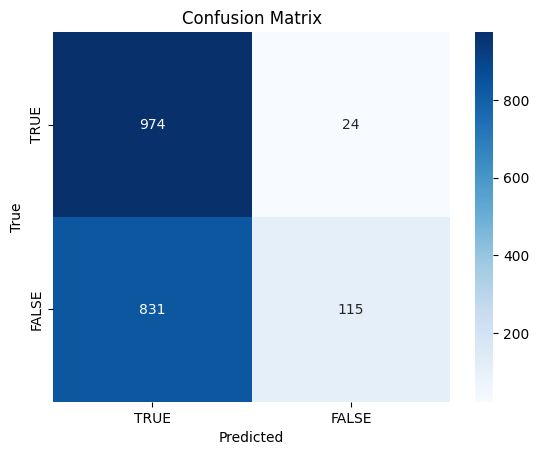

In [110]:
# Plot the confusion matrix with axis labels using seaborn
labels = ['TRUE', 'FALSE']
sns.heatmap(conf_mat_model_ets, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [111]:
model_ets.save_weights("/content/drive/MyDrive/Colab Notebooks/TB/final_weights/SimpleBERTClassifierETS_weights", save_format="tf")

In [ ]:
#model_ets.save("SimpleBERTClassifier_ETS", save_format="tf")

Input IDs shape: (None, 512)
Attention Mask shape: (None, 512)
Bert Outputs keys: odict_keys(['last_hidden_state', 'pooler_output'])
Pooled Output shape: (None, 768)
Output shape: (None, 1)
Input IDs shape: (None, 512)
Attention Mask shape: (None, 512)
Bert Outputs keys: odict_keys(['last_hidden_state', 'pooler_output'])
Pooled Output shape: (None, 768)
Output shape: (None, 1)
Input IDs shape: (None, 512)
Attention Mask shape: (None, 512)
Bert Outputs keys: odict_keys(['last_hidden_state', 'pooler_output'])
Pooled Output shape: (None, 768)
Output shape: (None, 1)


In [ ]:
#del model_ets
#del history_model_ets
#del evaluation_model_ets
#del predictions_model_ets

In [101]:
gc.collect()

73492

# DoubleBERTClassifier (Claims & ETS)

## Training

RESULTS :

In [102]:
history_double_model = double_model.fit(
    {'claim_input_ids': train_claim_input_ids,
    'claim_attention_mask': train_claim_attention_mask,
    'ets_input_ids': train_ets_input_ids,
    'ets_attention_mask': train_ets_attention_mask},
    y_train,
    epochs=num_epochs,
     validation_data=({'claim_input_ids': val_claim_input_ids, 'claim_attention_mask': val_claim_attention_mask,
                       'ets_input_ids': val_ets_input_ids, 'ets_attention_mask': val_ets_attention_mask}, y_val),
    batch_size=batch_size,
    callbacks=[model_checkpoint_double]
)

Epoch 1/11
Claim Input Shape:  (None, 115)
Claim Attention Mask Shape:  (None, 115)
ETS Input Shape:  (None, 115)
ETS Attention Mask Shape:  (None, 115)
Input Shape:  (None, None)
Attention Mask Shape:  (None, None)
Claim Input Shape:  (None, 115)
Claim Attention Mask Shape:  (None, 115)
ETS Input Shape:  (None, 115)
ETS Attention Mask Shape:  (None, 115)
Input Shape:  (None, None)
Attention Mask Shape:  (None, None)
622/622 [==============================] - ETA: 0s - loss: 0.4760 - accuracy: 0.8030 - precision: 0.8150 - recall: 0.7574 - auc: 0.8454 - false_positives: 508.0000 - false_negatives: 717.0000 - true_negatives: 2756.0000 - f1_score: 0.6442Claim Input Shape:  (None, 115)
Claim Attention Mask Shape:  (None, 115)
ETS Input Shape:  (None, 115)
ETS Attention Mask Shape:  (None, 115)
Input Shape:  (None, None)
Attention Mask Shape:  (None, None)

Epoch 1: val_auc improved from -inf to 0.89421, saving model to /content/drive/MyDrive/Colab Notebooks/TB/model_checkpoints/model_doubl

In [103]:
history_double_model.history

{'loss': [0.47601643204689026,
  0.34810641407966614,
  0.191011443734169,
  0.07100605964660645,
  0.035788677632808685,
  0.031092990189790726,
  0.02907160483300686,
  0.023157820105552673,
  0.02602933533489704,
  0.015282640233635902,
  0.015292542986571789],
 'accuracy': [0.8030229806900024,
  0.8610709309577942,
  0.9276410937309265,
  0.9760411381721497,
  0.9885833859443665,
  0.9921209216117859,
  0.9914777278900146,
  0.9914777278900146,
  0.9911561608314514,
  0.9959800839424133,
  0.9950152635574341],
 'precision': [0.8150036334991455,
  0.8649214506149292,
  0.9232848882675171,
  0.9733468294143677,
  0.9861766695976257,
  0.9922086596488953,
  0.9902027249336243,
  0.99219810962677,
  0.9911924004554749,
  0.9962736964225769,
  0.9952574372291565],
 'recall': [0.7573603987693787,
  0.8385787010192871,
  0.9245346784591675,
  0.9763113260269165,
  0.989847719669342,
  0.9912013411521912,
  0.9918781518936157,
  0.989847719669342,
  0.9901861548423767,
  0.9952622652053833

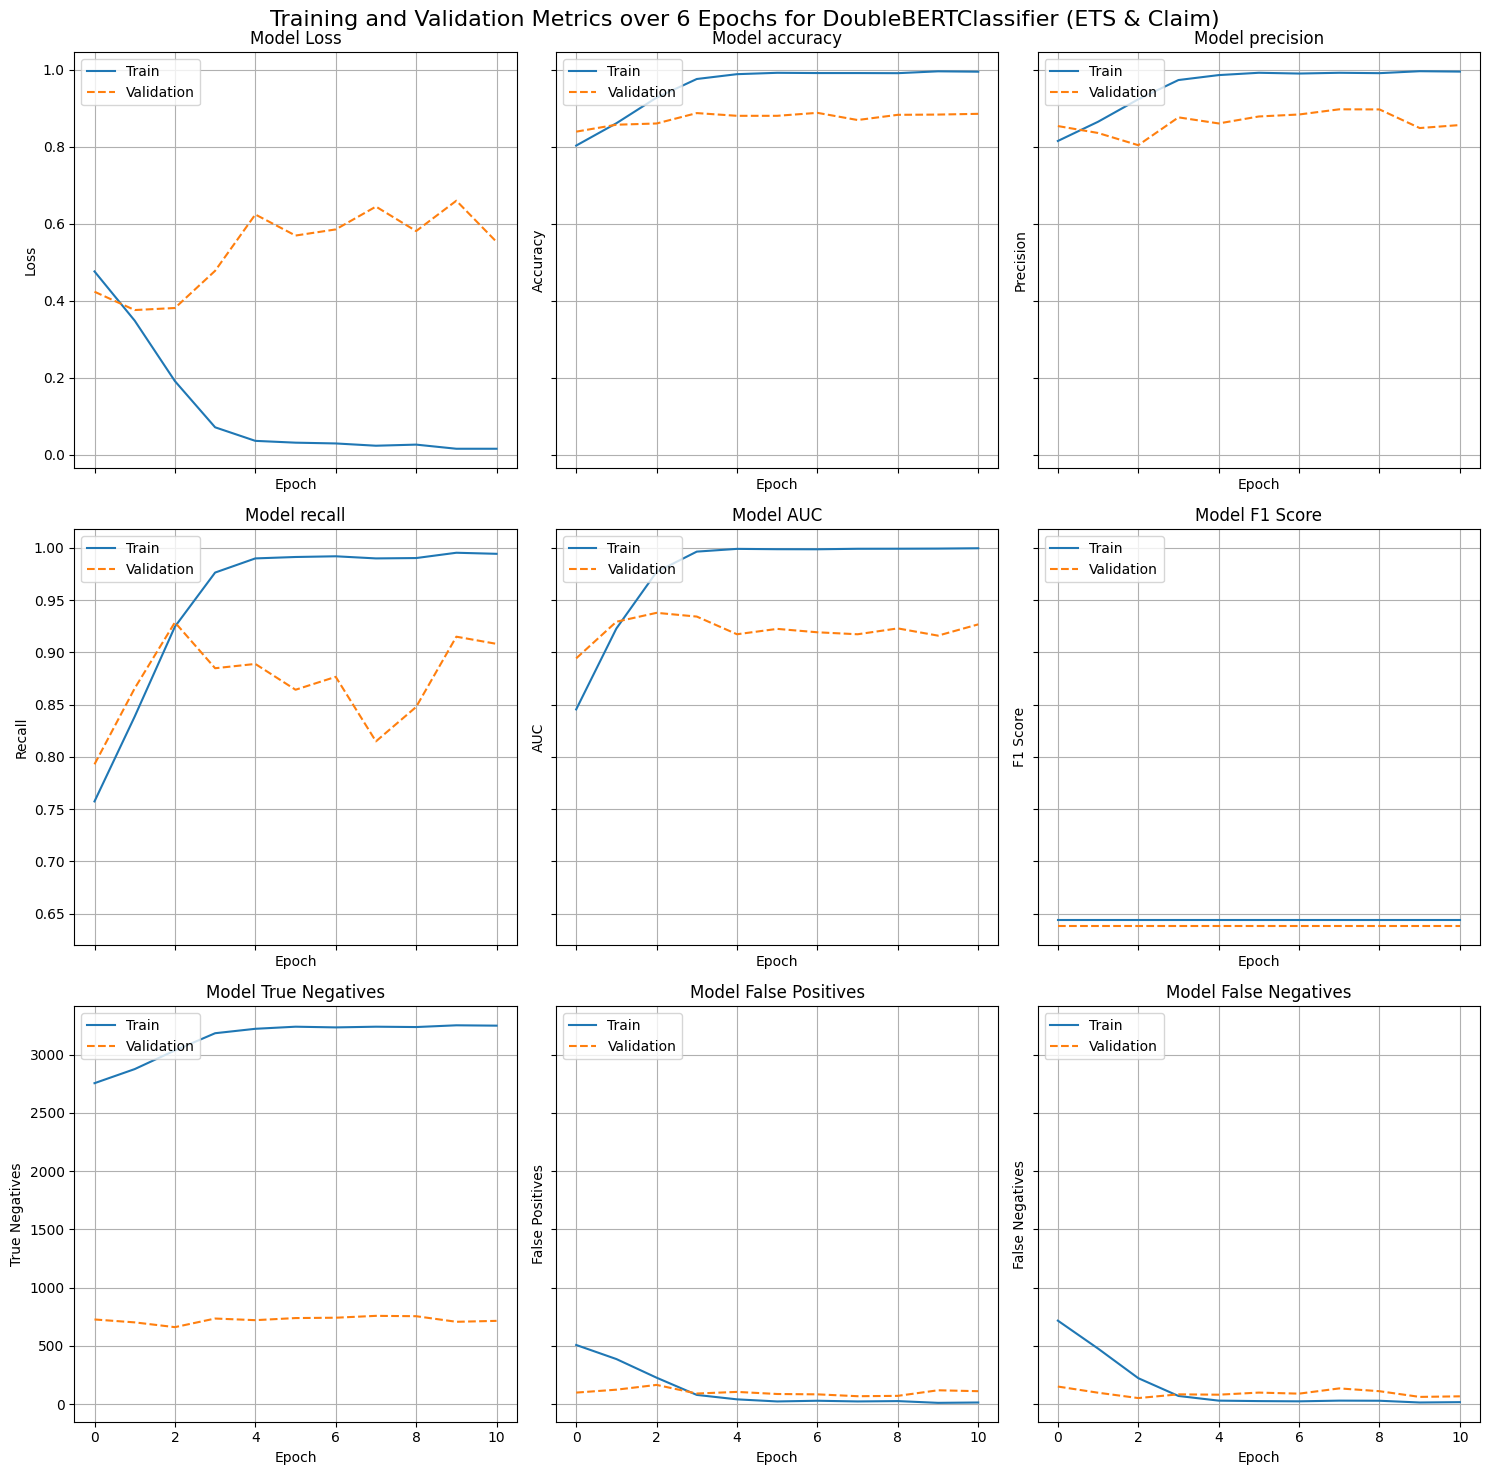

In [104]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=(True, True, False), sharey='row')

# Plot training & validation loss values
axes[0, 0].plot(history_double_model.history['loss'])
axes[0, 0].plot(history_double_model.history['val_loss'], linestyle='dashed')
axes[0, 0].set_title('Model Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend(['Train', 'Validation'], loc='upper left')
axes[0, 0].grid(True)

# Plot training & validation accuracy values
axes[0, 1].plot(history_double_model.history['accuracy'])
axes[0, 1].plot(history_double_model.history['val_accuracy'], linestyle='dashed')
axes[0, 1].set_title('Model accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend(['Train', 'Validation'], loc='upper left')
axes[0, 1].grid(True)

# Plot training & validation precision values
axes[0, 2].plot(history_double_model.history['precision'])
axes[0, 2].plot(history_double_model.history['val_precision'], linestyle='dashed')
axes[0, 2].set_title('Model precision')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Precision')
axes[0, 2].legend(['Train', 'Validation'], loc='upper left')
axes[0, 2].grid(True)

# Plot training & validation recall values
axes[1, 0].plot(history_double_model.history['recall'])
axes[1, 0].plot(history_double_model.history['val_recall'], linestyle='dashed')
axes[1, 0].set_title('Model recall')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].legend(['Train', 'Validation'], loc='upper left')
axes[1, 0].grid(True)

# Plot training & validation auc values
axes[1, 1].plot(history_double_model.history['auc'])
axes[1, 1].plot(history_double_model.history['val_auc'], linestyle='dashed')
axes[1, 1].set_title('Model AUC')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('AUC')
axes[1, 1].legend(['Train', 'Validation'], loc='upper left')
axes[1, 1].grid(True)

# Plot training & validation f1_score values
axes[1, 2].plot(history_double_model.history['f1_score'])
axes[1, 2].plot(history_double_model.history['val_f1_score'], linestyle='dashed')
axes[1, 2].set_title('Model F1 Score')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('F1 Score')
axes[1, 2].legend(['Train', 'Validation'], loc='upper left')
axes[1, 2].grid(True)

# Plot training & validation true negatives values
axes[2, 0].plot(history_double_model.history['true_negatives'])
axes[2, 0].plot(history_double_model.history['val_true_negatives'], linestyle='dashed')
axes[2, 0].set_title('Model True Negatives')
axes[2, 0].set_xlabel('Epoch')
axes[2, 0].set_ylabel('True Negatives')
axes[2, 0].legend(['Train', 'Validation'], loc='upper left')
axes[2, 0].grid(True)

# Plot training & validation false positives values
axes[2, 1].plot(history_double_model.history['false_positives'])
axes[2, 1].plot(history_double_model.history['val_false_positives'], linestyle='dashed')
axes[2, 1].set_title('Model False Positives')
axes[2, 1].set_xlabel('Epoch')
axes[2, 1].set_ylabel('False Positives')
axes[2, 1].legend(['Train', 'Validation'], loc='upper left')
axes[2, 1].grid(True)

# Plot training & validation false negatives values
axes[2, 2].plot(history_double_model.history['false_negatives'])
axes[2, 2].plot(history_double_model.history['val_false_negatives'], linestyle='dashed')
axes[2, 2].set_title('Model False Negatives')
axes[2, 2].set_xlabel('Epoch')
axes[2, 2].set_ylabel('False Negatives')
axes[2, 2].legend(['Train', 'Validation'], loc='upper left')
axes[2, 2].grid(True)

plt.suptitle('Training and Validation Metrics over 6 Epochs for DoubleBERTClassifier (ETS & Claim)', fontsize=16)
plt.tight_layout()
plt.show()

## Evaluate

In [112]:
double_model.load_weights(model_checkpoint_path + 'model_double_weights_03_0.3810.h5') #third epoch

In [113]:
evaluation_double_model = double_model.evaluate({'claim_input_ids': test_claim_input_ids, 'claim_attention_mask': test_claim_attention_mask,
                                                 'ets_input_ids': test_ets_input_ids, 'ets_attention_mask': test_ets_attention_mask},
                            y_test)

metrics_names = double_model.metrics_names

print('Metrics for the SimpleBERTClassifier (ETS) model with the lowest validation loss')
for metric_name, metric_value in zip(metrics_names, evaluation_double_model):
    print(f"{metric_name}: {metric_value:.4f}")

61/61 [==============================] - 24s 385ms/step - loss: 0.3620 - accuracy: 0.8647 - precision: 0.8124 - recall: 0.9387 - auc: 0.9408 - false_positives: 205.0000 - false_negatives: 58.0000 - true_negatives: 793.0000 - f1_score: 0.6547
Metrics for the SimpleBERTClassifier (ETS) model with the lowest validation loss
loss: 0.3620
accuracy: 0.8647
precision: 0.8124
recall: 0.9387
auc: 0.9408
false_positives: 205.0000
false_negatives: 58.0000
true_negatives: 793.0000
f1_score: 0.6547


## Prediction

RESULTS :

In [114]:
# Using the model to make predictions on test data (only Claim as the user will do)
ets_input_ids_zeros = tf.zeros((test_claim_input_ids.shape[0], 512), dtype=tf.int32)
ets_attention_mask_zeros = tf.zeros((test_claim_attention_mask.shape[0], 512), dtype=tf.int32)

print(test_claim_input_ids.shape, test_claim_attention_mask.shape, ets_input_ids_zeros.shape, ets_attention_mask_zeros.shape)


predictions_double_model = double_model.predict({'claim_input_ids': test_claim_input_ids, 'claim_attention_mask': test_claim_attention_mask,
                                                 'ets_input_ids': ets_input_ids_zeros, 'ets_attention_mask': ets_attention_mask_zeros})

predicted_labels = np.round(predictions_double_model)

(1944, 512) (1944, 512) (1944, 512) (1944, 512)
Claim Input Shape:  (None, 115)
Claim Attention Mask Shape:  (None, 115)
ETS Input Shape:  (None, 115)
ETS Attention Mask Shape:  (None, 115)
Input Shape:  (None, None)
Attention Mask Shape:  (None, None)
61/61 [==============================] - 9s 89ms/step


In [115]:
print(f'Predicted labels: {predictions_double_model}')
print(f'Rounded predicted labels: {predicted_labels}')

accuracy_double_model = accuracy_score(y_test, predicted_labels)
print(f'Accuracy: {accuracy_double_model:.4f}')

# Generate a confusion matrix
conf_mat_double_model = confusion_matrix(y_test, predicted_labels)
print('Confusion Matrix:')
print(conf_mat_double_model)

Predicted labels: [[0.7853272 ]
 [0.9455252 ]
 [0.05099987]
 ...
 [0.99285924]
 [0.82356936]
 [0.5638263 ]]
Rounded predicted labels: [[1.]
 [1.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]
Accuracy: 0.8297
Confusion Matrix:
[[736 262]
 [ 69 877]]


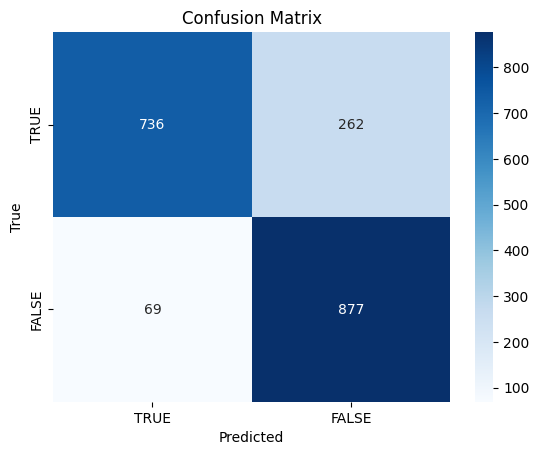

In [116]:
# Plot the confusion matrix with axis labels using seaborn
labels = ['TRUE', 'FALSE']
sns.heatmap(conf_mat_double_model, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [117]:
double_model.save_weights("/content/drive/MyDrive/Colab Notebooks/TB/final_weights/DoubleBERTClassifier_weights", save_format="tf")

In [ ]:
#double_model.save("DoubleBERTClassifier", save_format="tf")

# Model Comparison

## Training

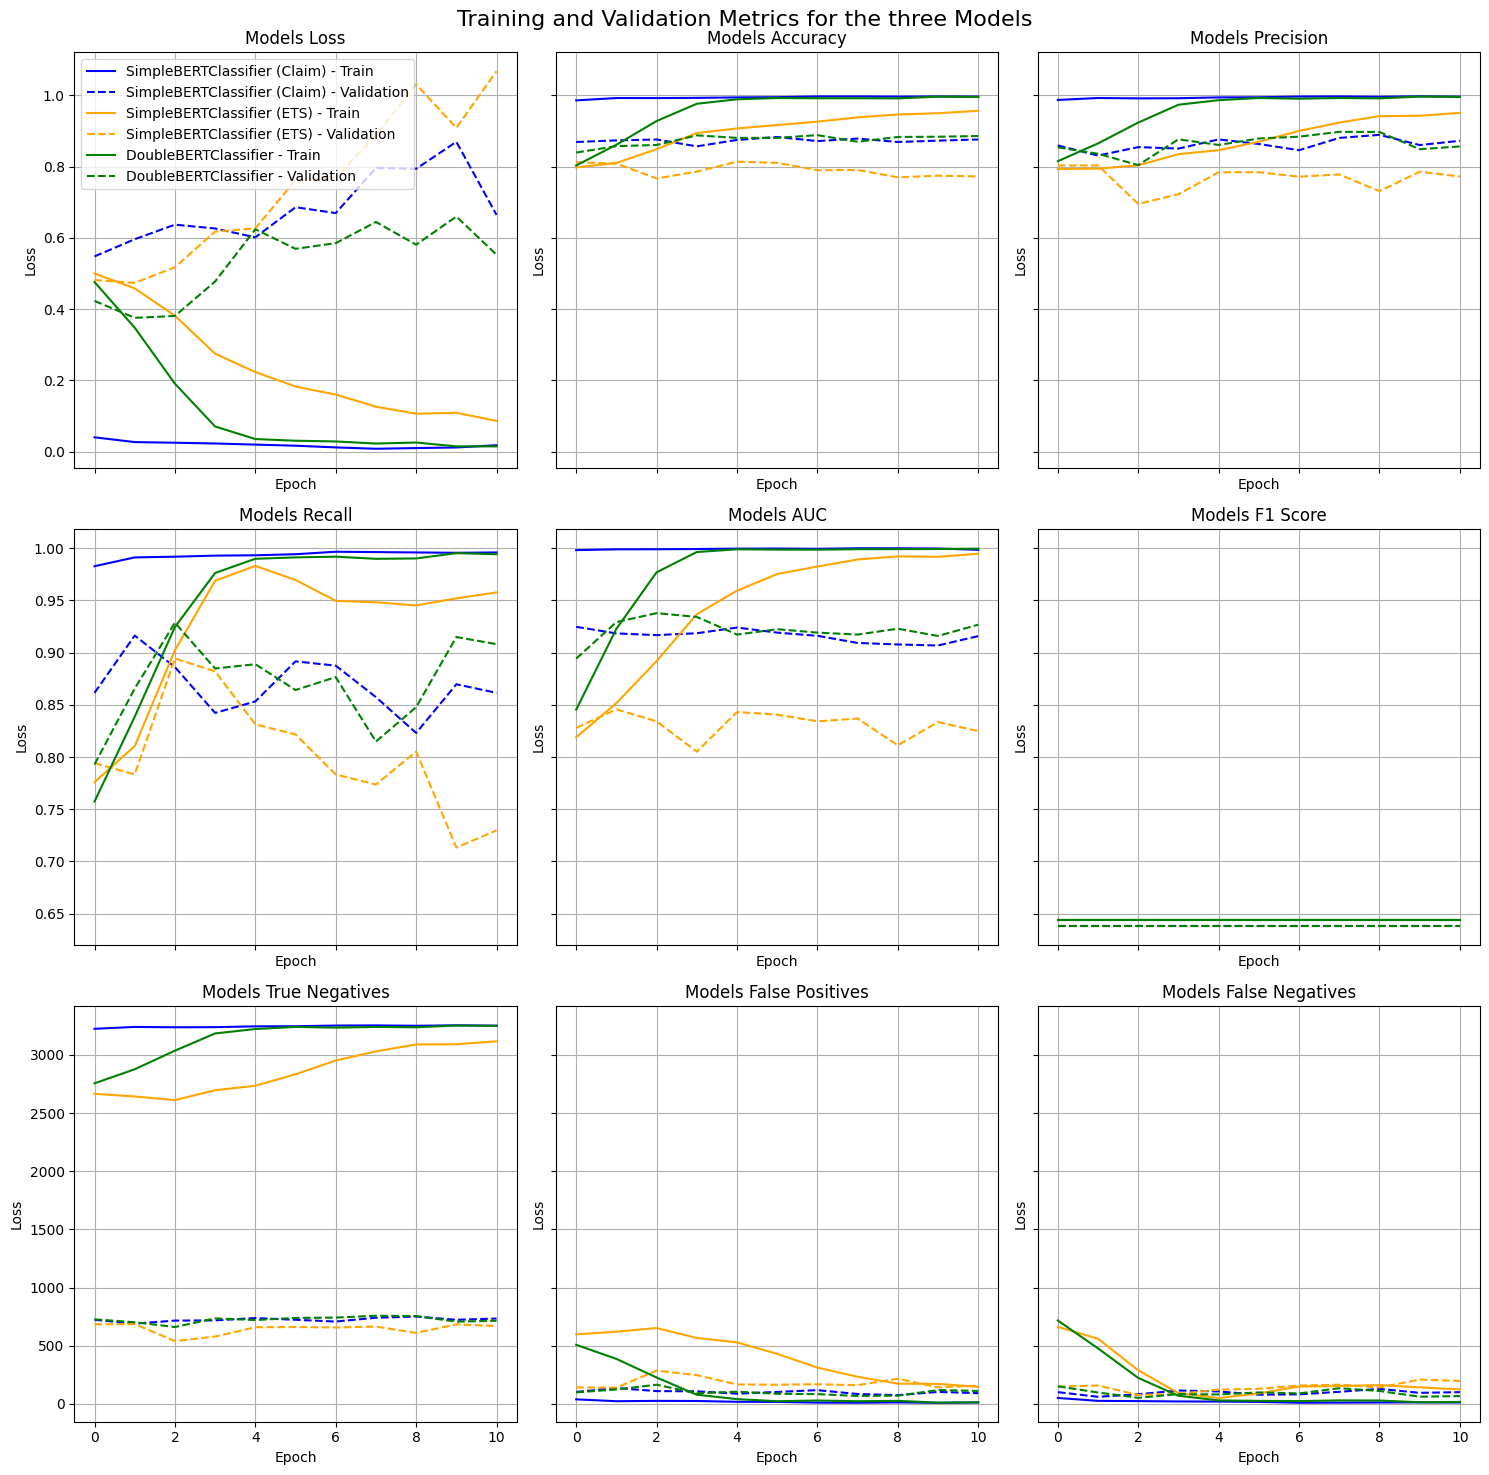

In [119]:
histories = [history_model_claim, history_model_ets, history_double_model]
model_names = ['SimpleBERTClassifier (Claim)', 'SimpleBERTClassifier (ETS)', 'DoubleBERTClassifier']
colors = ['blue', 'orange', 'green']

fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=(True, True, False), sharey='row')

for color, history, model_name in zip(colors, histories, model_names):
    # Plot training & validation loss values
    axes[0, 0].plot(history.history['loss'], label=f'{model_name} - Train', color=color)
    axes[0, 0].plot(history.history['val_loss'], label=f'{model_name} - Validation', color=color, linestyle='dashed')

    # Plot training & validation accuracy values
    axes[0, 1].plot(history.history['accuracy'], label=f'{model_name} - Train', color=color)
    axes[0, 1].plot(history.history['val_accuracy'], label=f'{model_name} - Validation', color=color, linestyle='dashed')

    # Plot training & validation precision values
    axes[0, 2].plot(history.history['precision'], label=f'{model_name} - Train', color=color)
    axes[0, 2].plot(history.history['val_precision'], label=f'{model_name} - Validation', color=color, linestyle='dashed')

    # Plot training & validation precision recall
    axes[1, 0].plot(history.history['recall'], label=f'{model_name} - Train', color=color)
    axes[1, 0].plot(history.history['val_recall'], label=f'{model_name} - Validation', color=color, linestyle='dashed')

    # Plot training & validation auc values
    axes[1, 1].plot(history.history['auc'], label=f'{model_name} - Train', color=color)
    axes[1, 1].plot(history.history['val_auc'], label=f'{model_name} - Validation', color=color, linestyle='dashed')

    # Plot training & validation F1 Score values
    axes[1, 2].plot(history.history['f1_score'], label=f'{model_name} - Train', color=color)
    axes[1, 2].plot(history.history['val_f1_score'], label=f'{model_name} - Validation', color=color, linestyle='dashed')

    # Plot training & validation auc true_negatives
    axes[2, 0].plot(history.history['true_negatives'], label=f'{model_name} - Train', color=color)
    axes[2, 0].plot(history.history['val_true_negatives'], label=f'{model_name} - Validation', color=color, linestyle='dashed')

    # Plot training & validation auc false_positives
    axes[2, 1].plot(history.history['false_positives'], label=f'{model_name} - Train', color=color)
    axes[2, 1].plot(history.history['val_false_positives'], label=f'{model_name} - Validation', color=color, linestyle='dashed')

     # Plot training & validation auc false_negatives
    axes[2, 2].plot(history.history['false_negatives'], label=f'{model_name} - Train', color=color)
    axes[2, 2].plot(history.history['val_false_negatives'], label=f'{model_name} - Validation', color=color, linestyle='dashed')


# Add legends to the plots
axes[0, 0].legend(loc='upper left')

# Set titles and labels
axes[0, 0].set_title('Models Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].grid(True)

axes[0, 1].set_title('Models Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].grid(True)

axes[0, 2].set_title('Models Precision')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Loss')
axes[0, 2].grid(True)

axes[1, 0].set_title('Models Recall')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].grid(True)

axes[1, 1].set_title('Models AUC')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].grid(True)

axes[1, 2].set_title('Models F1 Score')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Loss')
axes[1, 2].grid(True)

axes[2, 0].set_title('Models True Negatives')
axes[2, 0].set_xlabel('Epoch')
axes[2, 0].set_ylabel('Loss')
axes[2, 0].grid(True)

axes[2, 1].set_title('Models False Positives')
axes[2, 1].set_xlabel('Epoch')
axes[2, 1].set_ylabel('Loss')
axes[2, 1].grid(True)

axes[2, 2].set_title('Models False Negatives')
axes[2, 2].set_xlabel('Epoch')
axes[2, 2].set_ylabel('Loss')
axes[2, 2].grid(True)

# Adjust layout
plt.suptitle('Training and Validation Metrics for the three Models', fontsize=16)
plt.tight_layout()
plt.show()

## Evaluation

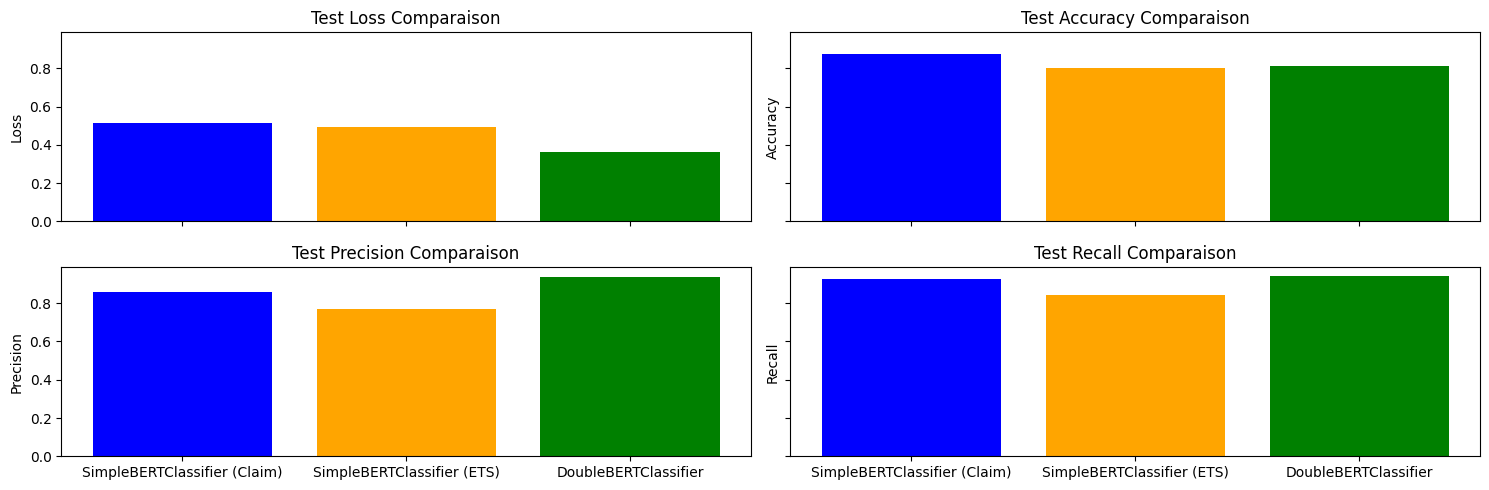

In [129]:
evaluations = [evaluation_model_claim, evaluation_model_ets, evaluation_double_model]

test_losses = [evaluation[0] for evaluation in evaluations]
test_accuracies = [evaluation[2] for evaluation in evaluations]
test_precisions = [evaluation[3] for evaluation in evaluations]
test_recall = [evaluation[4] for evaluation in evaluations]
test_auc = [evaluation[5] for evaluation in evaluations]


fig, axes = plt.subplots(2, 2, figsize=(15, 5), sharex='all', sharey='all')

axes[0, 0].bar(model_names, test_losses, color=['blue', 'orange', 'green'])
axes[0, 0].set_title('Test Loss Comparaison')
axes[0, 0].set_ylabel('Loss')

axes[0, 1].bar(model_names, test_accuracies, color=['blue', 'orange', 'green'])
axes[0, 1].set_title('Test Accuracy Comparaison')
axes[0, 1].set_ylabel('Accuracy')

axes[1, 0].bar(model_names, test_precisions, color=['blue', 'orange', 'green'])
axes[1, 0].set_title('Test Precision Comparaison')
axes[1, 0].set_ylabel('Precision')

axes[1, 1].bar(model_names, test_recall, color=['blue', 'orange', 'green'])
axes[1, 1].set_title('Test Recall Comparaison')
axes[1, 1].set_ylabel('Recall')

plt.tight_layout()
plt.show()

## Prediction

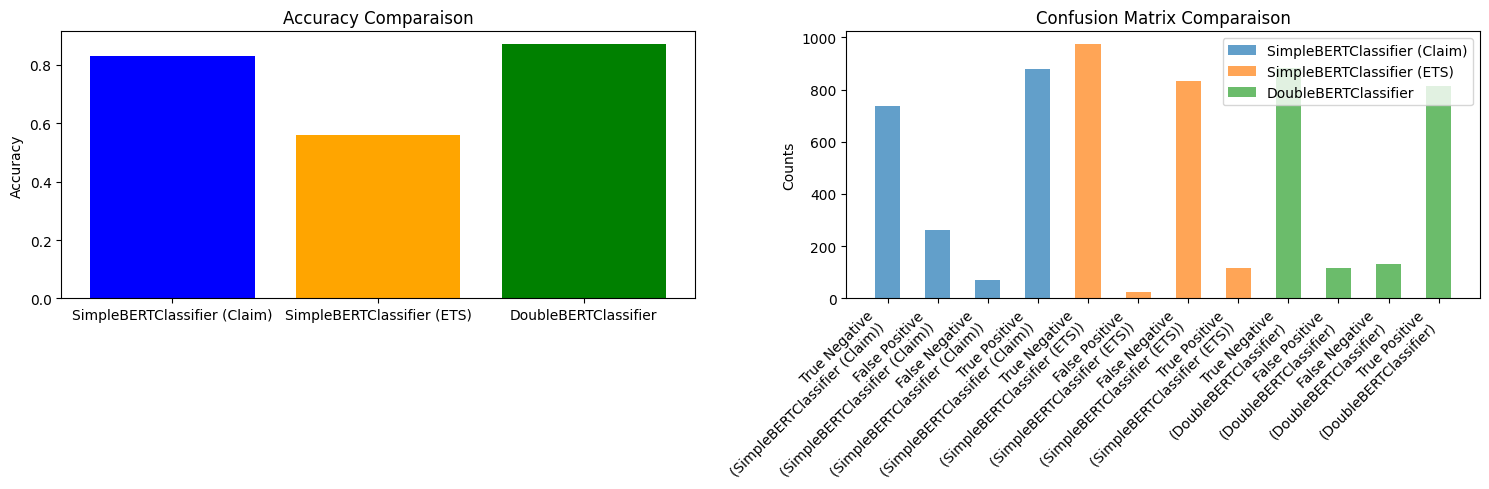

In [128]:
# Assuming you have accuracy values and confusion matrices for three models
accuracies = [accuracy_double_model, accuracy_model_ets, accuracy_model_claim]
confusion_matrices = [conf_mat_double_model, conf_mat_model_ets, conf_mat_model_claim]
model_names = ['SimpleBERTClassifier (Claim)', 'SimpleBERTClassifier (ETS)', 'DoubleBERTClassifier']

# Create a bar chart for accuracy comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Extract relevant metrics for comparison
accuracy_values = [accuracy for accuracy in accuracies]

axes[0].bar(model_names, accuracy_values, color=['blue', 'orange', 'green'])
axes[0].set_title('Accuracy Comparaison')
axes[0].set_ylabel('Accuracy')

# Create a bar chart for confusion matrix comparison (assuming binary classification)
labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']

for i, values in enumerate(confusion_matrices):
    model_name = model_names[i]
    axes[1].bar([f'{label}\n({model_name})' for label in labels], values.ravel(), alpha=0.7, width=0.5, label=f'{model_name}')

axes[1].set_xticks(axes[1].get_xticks())
axes[1].set_xticklabels([label.get_text() for label in axes[1].get_xticklabels()], rotation=45, ha='right')

axes[1].set_title('Confusion Matrix Comparaison')
axes[1].set_ylabel('Counts')
axes[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()